In [1]:
import glob
import pandas as pd
from dask import delayed, compute
from dask.distributed import Client
from solardatatools import DataHandler
from sdt_dask.dataplugs.pvdb_plug import PVDBPlug

# Create user defined data plug and pull from Red Shift

In [3]:
PVDBPlug?

Init signature:
PVDBPlug(
    api_key='3160e67b3cc54e8e9e288319a6479c37',
    power_col='meas_val_f',
)
Docstring:     
Dataplug class for retrieving data from the PVDB (Redshift) database.
    
File:           ~/Desktop/SLAC/solar-data-tools/sdt_dask/dataplugs/pvdb_plug.py
Type:           type
Subclasses:     

In [4]:
data_plug = PVDBPlug()
KEYS = [("TABJC1027159", 0), ("TAAI01129193", 0)]
data_plug.get_data(KEYS[0])

,meas_val_f
ts,
2016-03-28 20:40:00,1.1394
2016-03-28 20:45:00,1.4464
2016-03-28 20:50:00,1.1930
2016-03-28 20:55:00,2.1952
2016-03-28 21:00:00,1.4514
...,...
2019-06-20 23:30:00,0.4866
2019-06-20 23:35:00,0.4978
2019-06-20 23:40:00,0.4789


# Create SDT Dask task graph (run in parallel on multiple files)

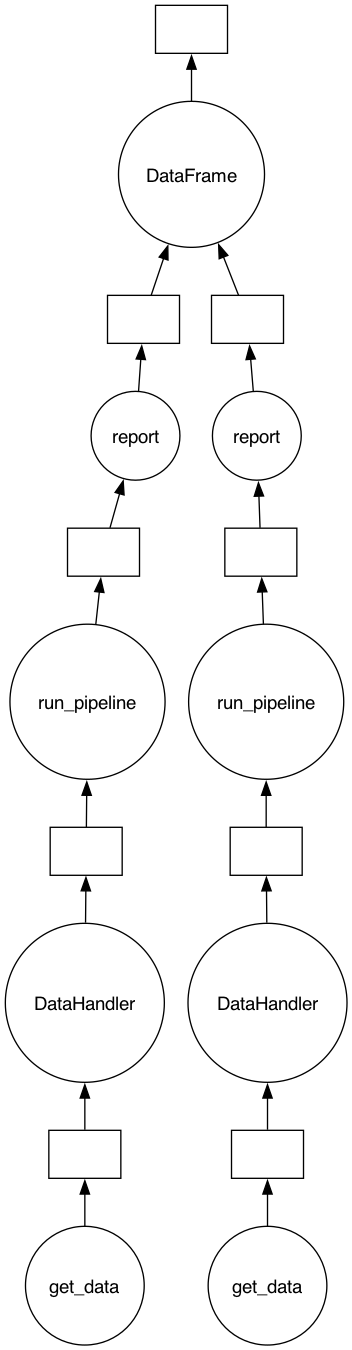

In [5]:
# Define the pipeline run for as single dataset
def run_pipeline(datahandler, solver, solver_convex, verbose=False):
    # Need to call this separately to have it run correctly in task graph 
    # since it doesn't return anything
    datahandler.run_pipeline(solver=solver, solver_convex=solver_convex, verbose=verbose)
    return datahandler


# Call above functions in a for loop over the keys
# and collect results in a DataFrame
reports = []

for key in KEYS:
    
    df = delayed(data_plug.get_data)(key)
    dh = delayed(DataHandler)(df)
    dh_run = delayed(run_pipeline)(dh, solver="OSQP", solver_convex="OSQP", verbose=True)
    report = dh_run.report
    report = delayed(report)(return_values=True, verbose=False)
    reports.append(report)

df_reports = delayed(pd.DataFrame)(reports)

# Visualizing the graph
df_reports.visualize()

In [6]:
client = Client(memory_limit='32GB') 
client.dashboard_link

2024-03-12 12:18:29,958 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 32GB due to system memory limit of 16.00 GiB
2024-03-12 12:18:29,960 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 32GB due to system memory limit of 16.00 GiB
2024-03-12 12:18:29,962 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 32GB due to system memory limit of 16.00 GiB
2024-03-12 12:18:29,963 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 32GB due to system memory limit of 16.00 GiB
2024-03-12 12:18:29,965 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 32GB due to system memory limit of 16.00 GiB


'http://127.0.0.1:8787/status'

In [7]:
summary_table = client.compute(df_reports)
summary_table

<Future: pending, key: DataFrame-76bcd157-0091-41e4-a166-8bdfd7c5f869>

In [8]:
summary_table.result()

/Users/liuhaoyang/Desktop/SLAC/solar-data-tools/solardatatools/time_axis_manipulation.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[0] >= thresh:
/Users/liuhaoyang/Desktop/SLAC/solar-data-tools/solardatatools/time_axis_manipulation.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[-1] >= thresh:
/Users/liuhaoyang/anaconda3/envs/SLAC/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/liuhaoyang/Desktop/SLAC/solar

total time: 11.08 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              0.93s
Cleaning                   1.07s
Filtering/Summarizing      9.07s
    Data quality           0.20s
    Clear day detect       1.84s
    Clipping detect        6.19s
    Capacity change detect 0.85s

total time: 24.89 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              4.43s
Cleaning                   3.82s
Filtering/Summarizing      16.63s
    Data quality           0.79s
    Clear day detect       3.50s
    Clipping detect        9.10s
    Capacity change detect 3.24s



,length,capacity,sampling,quality score,clearness score,inverter clipping,clipped fraction,capacity change,data quality warning,time shift correction,time zone correction
0,3.232877,3.7854,5,0.966949,0.513559,False,0.005085,True,True,False,-6
1,5.471233,6.6387,5,0.823235,0.433150,True,0.134702,True,True,False,-2


In [9]:
client.shutdown()